## Dataset Download

In [1]:
!pip install -q kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
100% 308M/309M [00:18<00:00, 16.6MB/s]
100% 309M/309M [00:18<00:00, 17.8MB/s]


In [4]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

## Library Imports

In [5]:
import cv2
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Resizing, Rescaling, Input, Conv2D, BatchNormalization,
             MaxPooling2D, Flatten, Dense, Dropout, RandomRotation, RandomFlip,
                RandomContrast, Layer, Activation,Add, GlobalAveragePooling2D)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from sklearn.metrics import confusion_matrix

from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Feature, Features, Example

## Dataset Loading

In [6]:
train_dataset_path = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_dataset_path = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry","happy","sad"]

In [7]:
CONFIGURATION = {
    "IM_SIZE":256,
    "BATCH_SIZE":32,
    "SEED":123,
    "LEARNING_RATE":0.001,
    "N_EPOCHS" : 20,
    "DROPOUT_RATE":0.0,
    "REGULARIZATION_RATE":0.0,
    "N_FILTERS":6,
    "KERNEL_SIZE":3,
    "N_STRIDES":1,
    "POOL_SIZE":2,
    "N_DENSE_1":1024,
    "N_DENSE_2":128,
    "NUM_CLASSES":3,
}

In [8]:
training_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    color_mode="rgb",
    batch_size=CONFIGURATION['BATCH_SIZE'],
    class_names=CLASS_NAMES,
    shuffle=True,
    seed=123
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_dataset_path,
    labels="inferred",
    label_mode="int",
    image_size=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    color_mode="rgb",
    batch_size=CONFIGURATION['BATCH_SIZE'],
    class_names=CLASS_NAMES,
    shuffle=True,
    seed=123
)

Found 6799 files belonging to 3 classes.
Found 2278 files belonging to 3 classes.


In [ ]:
for i in validation_dataset.take(1):
  print(i)

# if labels="categorical" class will be look like [0 0 1], [1 0 0]

## Data Visualization

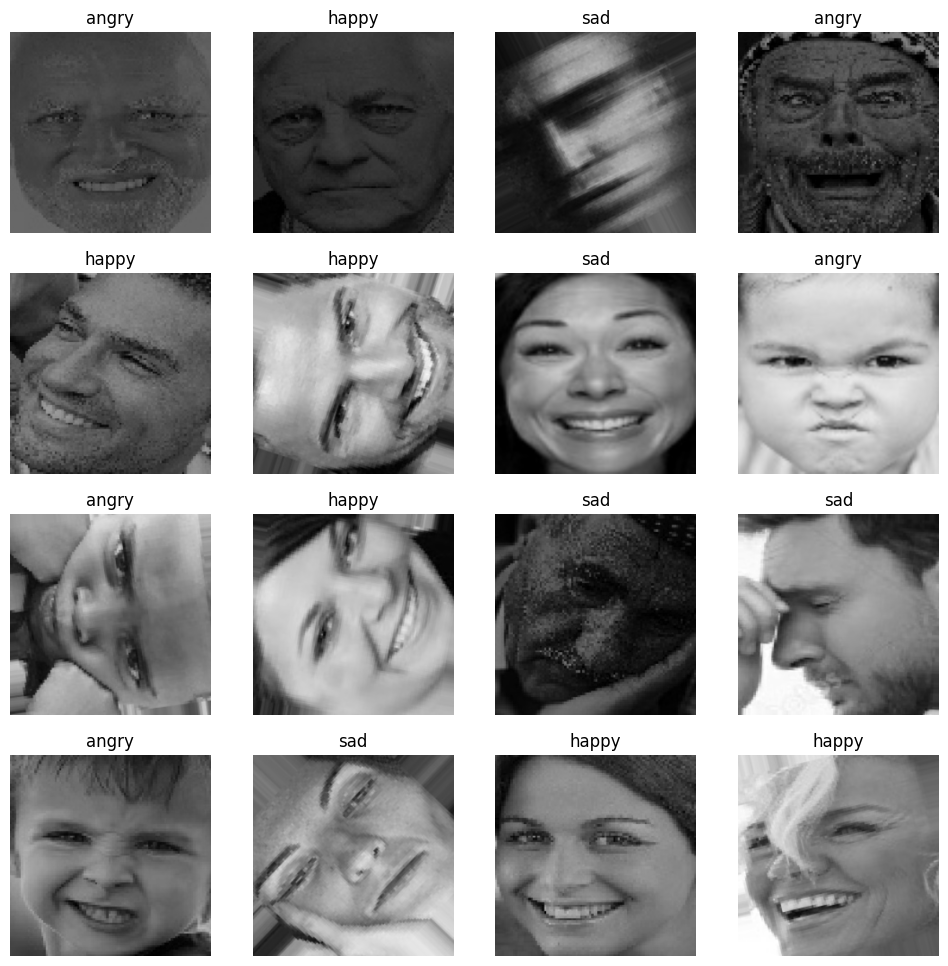

In [ ]:
plt.figure(figsize=(12,12))

for images,labels in training_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title(CLASS_NAMES[labels[i].numpy()])
        plt.axis("off")

## Dataset Preparation

In [ ]:
training_dataset

In [9]:
# we do augmantation only for training data
train_data = (training_dataset
              .prefetch(tf.data.AUTOTUNE))
val_data = (validation_dataset.prefetch(tf.data.AUTOTUNE))

In [10]:
resize_rescale_layer = tf.keras.Sequential([
    Resizing(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']),
    Rescaling(1./255)
])

In [11]:
loss_function = SparseCategoricalCrossentropy()

In [12]:
metrics = [CategoricalAccuracy(name="accuracy"),TopKCategoricalAccuracy(k=2,name="top_k_accuracy")]

### Transfer Learning with EfficientNet

In [13]:
effcientnet = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top=False,
    weights="imagenet",
    input_shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3),
)
# freezing efficient net parameters
effcientnet.trainable = False

71686520/71686520 [==============================] - 4s 0us/step


In [14]:
efficientnet_model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3)),
    effcientnet,
    GlobalAveragePooling2D(),
    Dense(CONFIGURATION['N_DENSE_1'],activation="relu"),
    BatchNormalization(),
    Dense(CONFIGURATION['N_DENSE_2'],activation="relu"),
    Dense(CONFIGURATION['NUM_CLASSES'],activation="softmax")
])
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional  (None, 8, 8, 1792)        17673823  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 1792)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1024)              1836032   
                                                                 
 batch_normalization (Batch  (None, 1024)              4096      
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               131200    
                                                      

### Transfer Learning with Resnet 34

In [15]:
class CustomConv2D(Layer):
    def __init__(self,n_filters, kernel_size, n_strides,padding='valid'):
        super(CustomConv2D,self).__init__(name="CustomConv2D")

        self.conv = Conv2D(
            filters=n_filters,
            kernel_size=kernel_size,
            activation='relu',
            strides=n_strides,
            padding=padding,
            )

        self.batch_norm = BatchNormalization()

    def call(self,x, training=True):
        x = self.conv(x)
        x = self.batch_norm(x,training)

        return x

In [16]:
class ResidualBlock(Layer):
    def __init__(self, n_channels,n_strides=1):
        super(ResidualBlock,self).__init__(name="ResidualBlock")

        self.dotted = n_strides != 1

        self.custom_conv1 = CustomConv2D(n_channels,3,n_strides,padding="same")
        self.custom_conv2 = CustomConv2D(n_channels,3,1,padding="same")

        self.activation = Activation("relu")

        if self.dotted:
            self.custom_conv3 = CustomConv2D(n_channels,1,n_strides)


    def call(self,input,training=True):
        x = self.custom_conv1(input,training)
        x = self.custom_conv2(x,training)

        if self.dotted:
            x_add = self.custom_conv3(input,training)
            x_add = Add()([x,x_add])
        else:
            x_add = Add()([x,input])

        return self.activation(x_add)


In [17]:
class ResNet34(Model):
    def __init__(self):
        super(ResNet34,self).__init__(name="ResNet34")

        self.conv1 = CustomConv2D(64,7,2,padding="same")
        self.max_pool = MaxPooling2D(pool_size=3,strides=2)

        self.conv_2_1 = ResidualBlock(64)
        self.conv_2_2 = ResidualBlock(64)
        self.conv_2_3 = ResidualBlock(64)

        self.conv_3_1 = ResidualBlock(128,2)
        self.conv_3_2 = ResidualBlock(128)
        self.conv_3_3 = ResidualBlock(128)
        self.conv_3_4 = ResidualBlock(128)

        self.conv_4_1 = ResidualBlock(256,2)
        self.conv_4_2 = ResidualBlock(256)
        self.conv_4_3 = ResidualBlock(256)
        self.conv_4_4 = ResidualBlock(256)
        self.conv_4_5 = ResidualBlock(256)
        self.conv_4_6 = ResidualBlock(256)

        self.conv_5_1 = ResidualBlock(512,2)
        self.conv_5_2 = ResidualBlock(512)
        self.conv_5_3 = ResidualBlock(512)

        self.global_pool = GlobalAveragePooling2D()

        self.fc = Dense(CONFIGURATION["NUM_CLASSES"],activation="softmax")

    def call(self,x,training=True):
        x = self.conv1(x)
        x = self.max_pool(x)

        x = self.conv_2_1(x,training)
        x = self.conv_2_2(x,training)
        x = self.conv_2_3(x,training)

        x = self.conv_3_1(x,training)
        x = self.conv_3_2(x,training)
        x = self.conv_3_3(x,training)
        x = self.conv_3_4(x,training)

        x = self.conv_4_1(x,training)
        x = self.conv_4_2(x,training)
        x = self.conv_4_3(x,training)
        x = self.conv_4_4(x,training)
        x = self.conv_4_5(x,training)
        x = self.conv_4_6(x,training)

        x = self.conv_5_1(x,training)
        x = self.conv_5_2(x,training)
        x = self.conv_5_3(x,training)

        x = self.global_pool(x)

        return self.fc(x)

In [18]:
resnet_34 = ResNet34()
resnet_34(tf.zeros(shape=(1,256,256,3)), training = False)
resnet_34.summary()

Model: "ResNet34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CustomConv2D (CustomConv2D  multiple                  9728      
 )                                                               
                                                                 
 max_pooling2d (MaxPooling2  multiple                  0         
 D)                                                              
                                                                 
 ResidualBlock (ResidualBlo  multiple                  74368     
 ck)                                                             
                                                                 
 ResidualBlock (ResidualBlo  multiple                  74368     
 ck)                                                             
                                                                 
 ResidualBlock (ResidualBlo  multiple                  743

## Ensembling

In [19]:
inputs = Input(shape=(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE'],3))

y_1 = resnet_34(inputs)
y_2 = efficientnet_model(inputs)

outputs = 0.5*y_1 + 0.5*y_2
ensemble_model = Model(inputs=inputs,outputs=outputs)


### Training

In [20]:
ensemble_model.compile(
    optimizer=Adam(learning_rate=CONFIGURATION["LEARNING_RATE"]),
    loss=loss_function,
    metrics=metrics
)

In [21]:
history = ensemble_model.fit(train_data,   # use only train data if not applying augmentation
                    # epochs=1,
                    epochs=CONFIGURATION["N_EPOCHS"],
                    validation_data=val_data,
                    verbose=1)

Epoch 1/20
213/213 [==============================] - 186s 663ms/step - loss: 0.9377 - accuracy: 0.2599 - top_k_accuracy: 0.4496 - val_loss: 1.0750 - val_accuracy: 0.5004 - val_top_k_accuracy: 0.7397
Epoch 2/20
213/213 [==============================] - 111s 522ms/step - loss: 0.7509 - accuracy: 0.2202 - top_k_accuracy: 0.3999 - val_loss: 0.8166 - val_accuracy: 0.2823 - val_top_k_accuracy: 0.5334
Epoch 3/20
213/213 [==============================] - 111s 521ms/step - loss: 0.6805 - accuracy: 0.2084 - top_k_accuracy: 0.3752 - val_loss: 0.9135 - val_accuracy: 0.1444 - val_top_k_accuracy: 0.4829
Epoch 4/20
213/213 [==============================] - 115s 539ms/step - loss: 0.6477 - accuracy: 0.1930 - top_k_accuracy: 0.3583 - val_loss: 0.8424 - val_accuracy: 0.2572 - val_top_k_accuracy: 0.5979
Epoch 5/20
213/213 [==============================] - 115s 540ms/step - loss: 0.6563 - accuracy: 0.1755 - top_k_accuracy: 0.3465 - val_loss: 0.7555 - val_accuracy: 0.1457 - val_top_k_accuracy: 0.4728


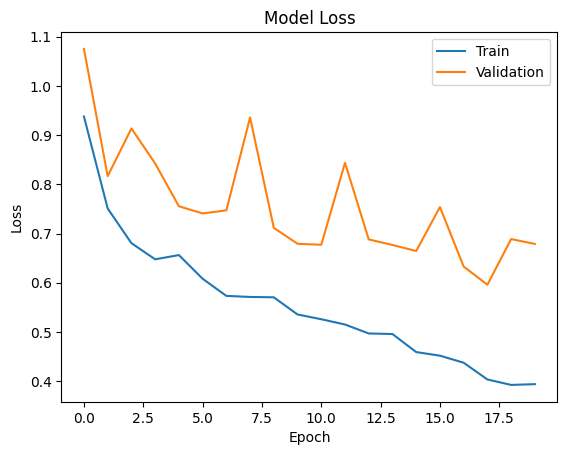

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

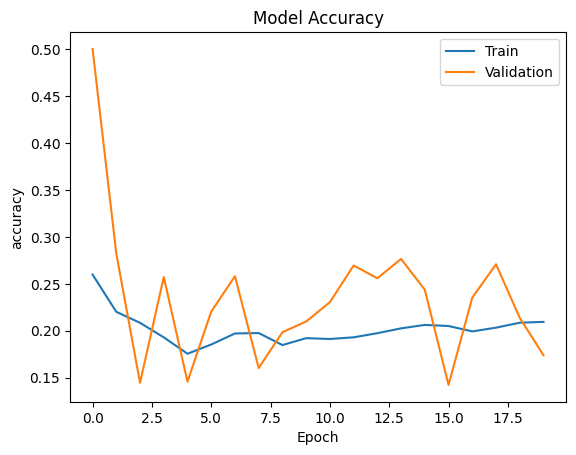

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Evaluation

In [24]:
ensemble_model.evaluate(val_data)

72/72 [==============================] - 18s 242ms/step - loss: 0.6788 - accuracy: 0.1738 - top_k_accuracy: 0.5219


[0.6788201928138733, 0.17383669316768646, 0.521949052810669]

## Testing

In [27]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/104188.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im,axis=0)

print(CLASS_NAMES[tf.argmax(ensemble_model(im),axis=-1).numpy()[0]])

sad


In [29]:
# sad example
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/10416.jpg_rotation_2.jpg")
test_image = cv2.resize(test_image,(CONFIGURATION['IM_SIZE'],CONFIGURATION['IM_SIZE']))
im = tf.constant(test_image,dtype=tf.float32)
im = tf.expand_dims(im,axis=0)

print(CLASS_NAMES[tf.argmax(ensemble_model(im),axis=-1).numpy()[0]])

happy


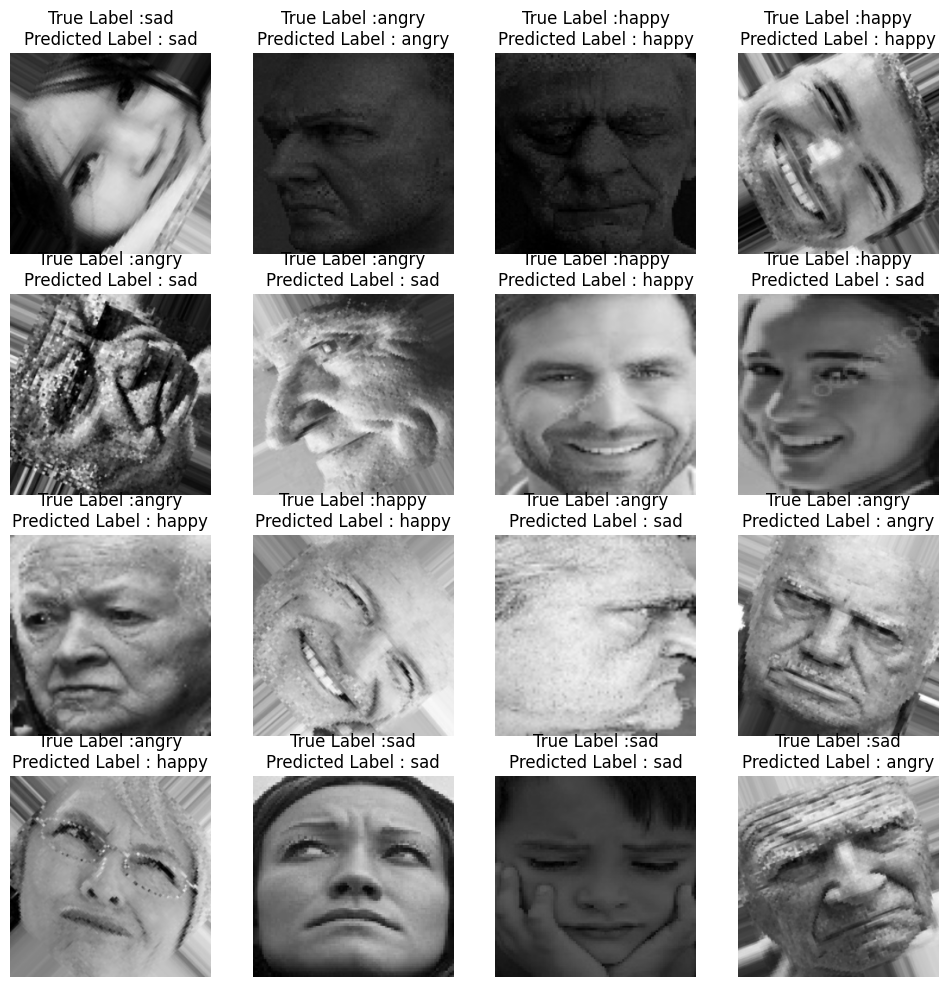

In [31]:
plt.figure(figsize=(12,12))

for images,labels in validation_dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i]/255.)
        plt.title("True Label :" + CLASS_NAMES[labels[i].numpy()] + "\n" + "Predicted Label : "+ CLASS_NAMES[tf.argmax(ensemble_model(tf.expand_dims(images[i],axis=0)),axis=-1).numpy()[0]])
        plt.axis("off")

## Confusion Matrix

In [32]:
labels = []
predicted = []
for im, label in validation_dataset:
    labels.append(label.numpy())
    predicted.append(tf.argmax(ensemble_model(im),axis=-1).numpy())

In [33]:
lab = np.concatenate(labels)
pred = np.concatenate(predicted)

In [ ]:
lab

array([0, 2, 1, ..., 1, 1, 1], dtype=int32)

[[332  69 114]
 [ 41 879  86]
 [ 51  83 623]]


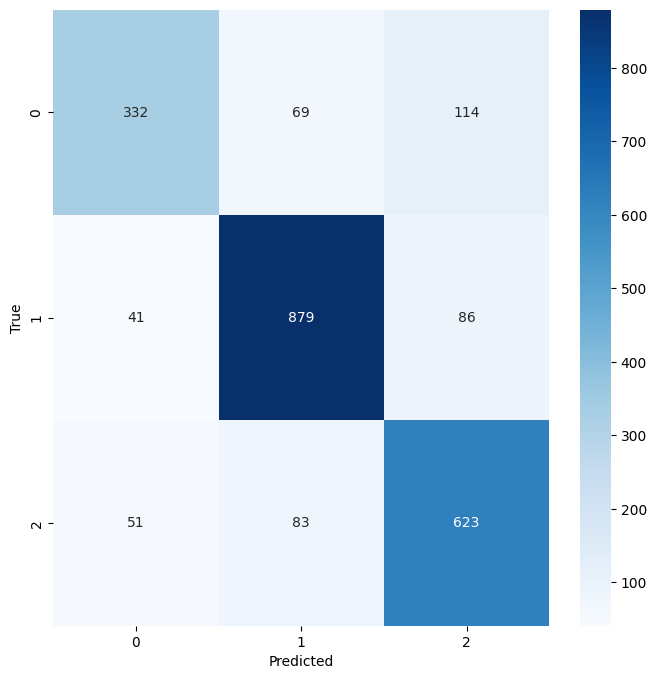

In [34]:
threshold = 0.5

cm = confusion_matrix(lab,pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm,annot=True,fmt="d",cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()